In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

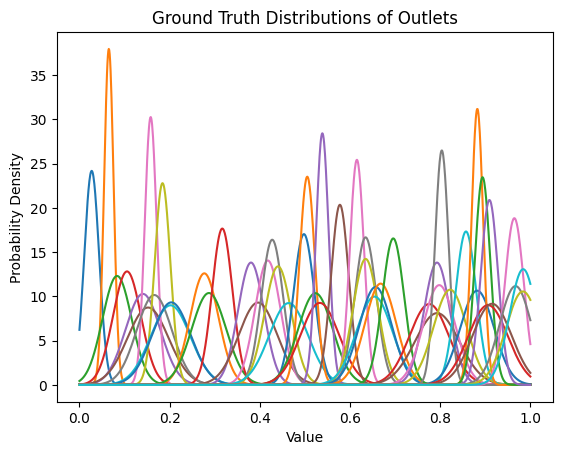

In [43]:
# Generate ground truth distributions
def generate_ground_truth(n_outlets, seed=None):
    if seed is not None:
        np.random.seed(seed)
    means = np.random.uniform(0, 1, n_outlets)
    means.sort()
    stds = np.random.uniform(0.01, 0.05, n_outlets)
    ground_truth = {
        f"Outlet {i+1}": {"mean": means[i], "std": stds[i]} for i in range(n_outlets)
    }

    return ground_truth

n_outlets = 50
ground_truth = generate_ground_truth(n_outlets)

x = np.linspace(0, 1, 1000)
for outlet, stats in ground_truth.items():
    mean = stats["mean"]
    std = stats["std"]
    y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    plt.plot(x, y, label=outlet)
plt.title("Ground Truth Distributions of Outlets")
plt.xlabel("Value")
plt.ylabel("Probability Density")
if n_outlets <= 10:
    plt.legend()
plt.show()

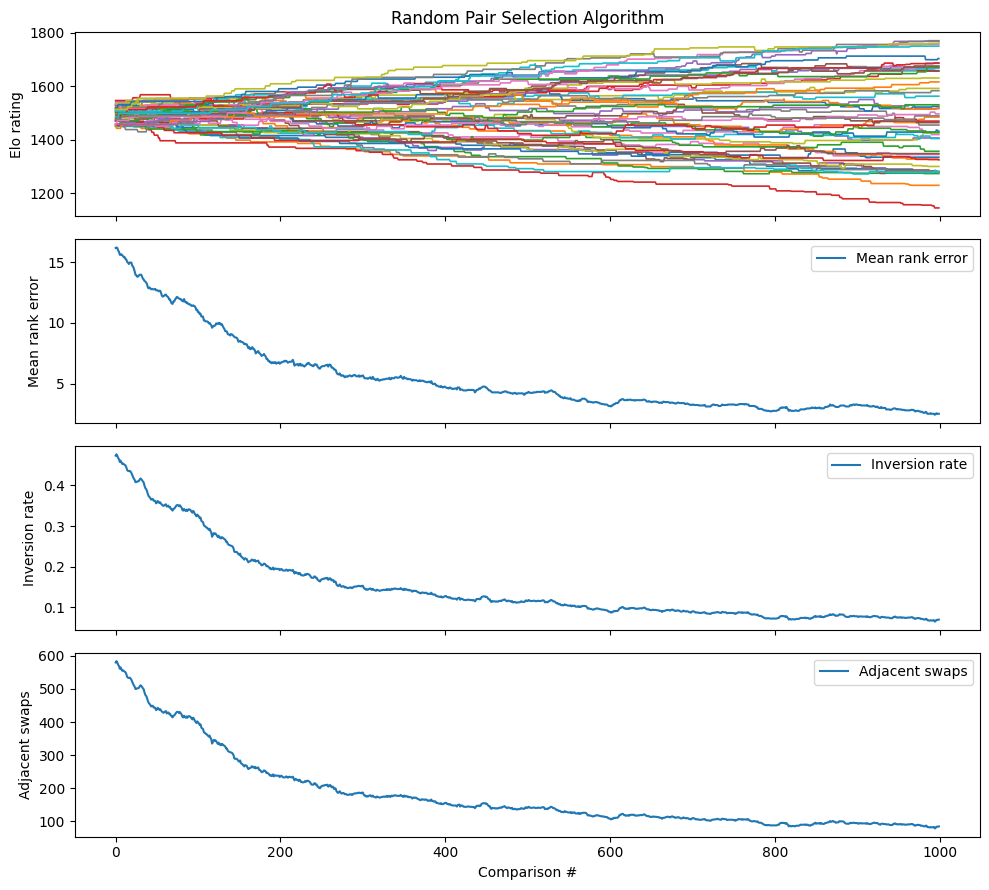

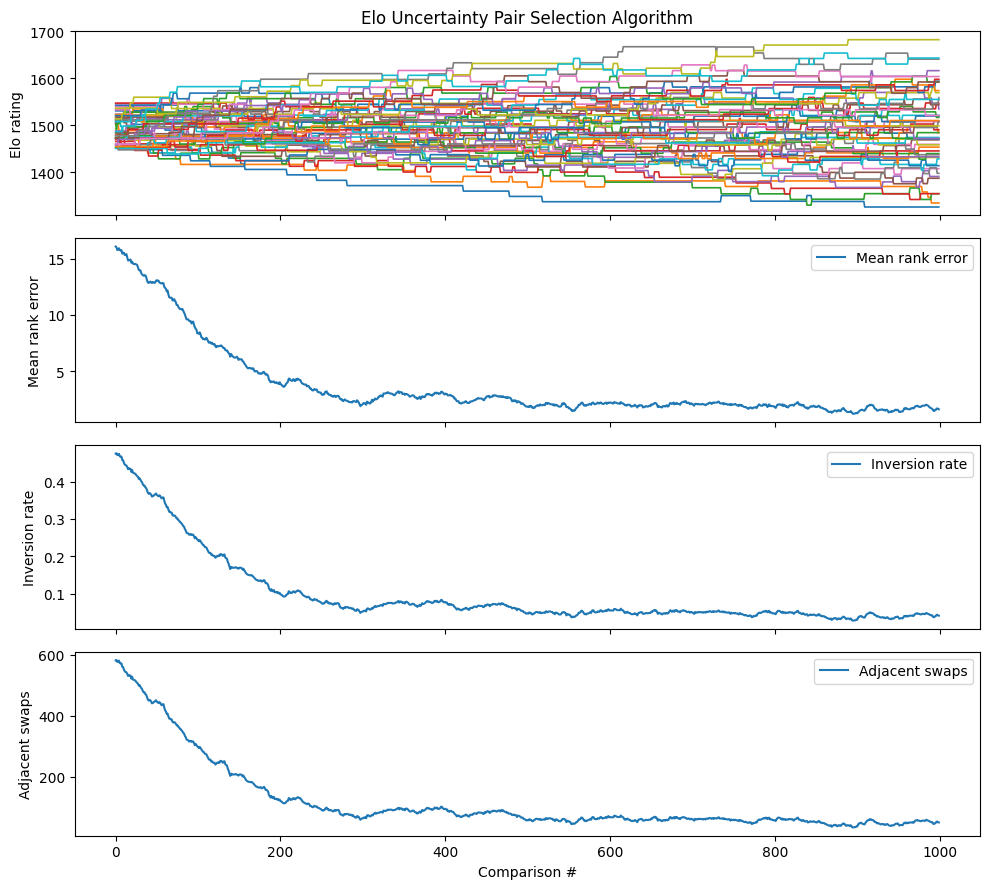

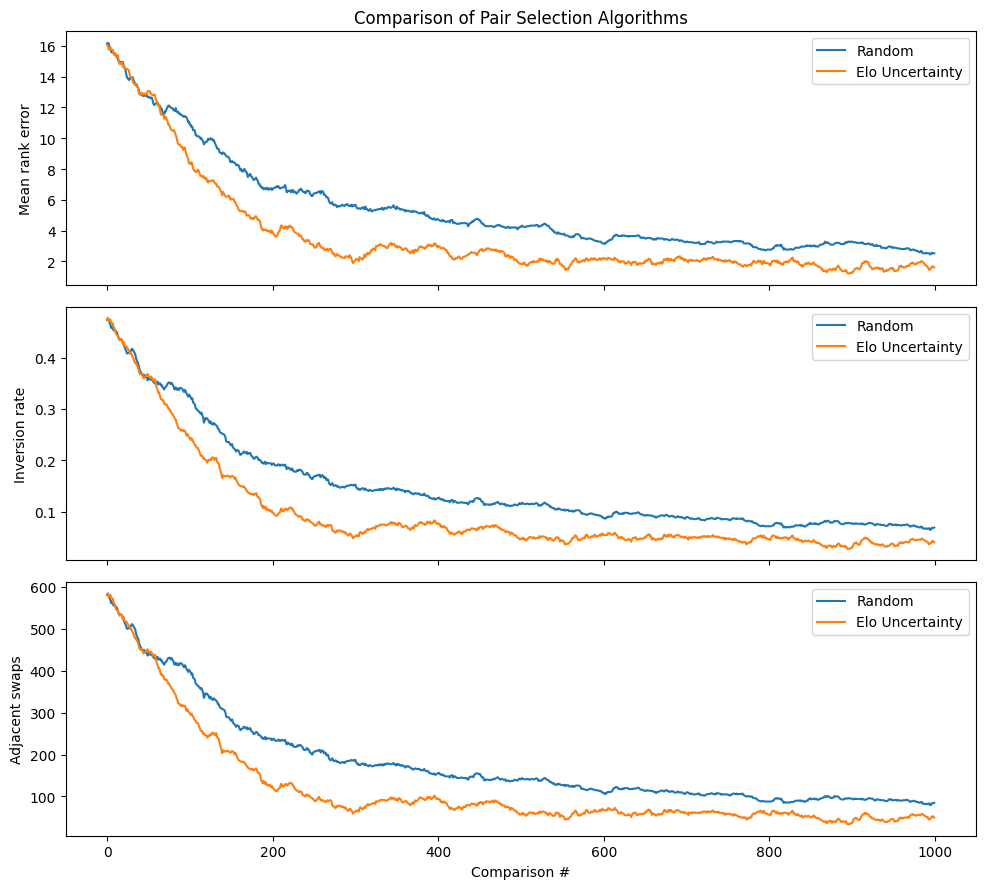

In [44]:
import math
outlets = list(ground_truth.keys())

# --- comparison simulator ---

def sample_position(outlet):
    mu = ground_truth[outlet]["mean"]
    sigma = ground_truth[outlet]["std"]
    value = random.gauss(mu, sigma)
    return min(max(value, 0.0), 1.0)

def compare(a, b):
    return a if sample_position(a) >= sample_position(b) else b

# --- ranking model (Elo) ---

def expected_score(ra, rb):
    return 1 / (1 + 10 ** ((rb - ra) / 400))


def update_elo(ratings, winner, loser, k=24):
    ea = expected_score(ratings[winner], ratings[loser])
    eb = expected_score(ratings[loser], ratings[winner])
    ratings[winner] += k * (1 - ea)
    ratings[loser] += k * (0 - eb)

# --- error metrics ---

def rank_error(ratings):
    true_order = sorted(outlets, key=lambda o: ground_truth[o]["mean"])
    true_rank = {o: i for i, o in enumerate(true_order)}
    est_order = sorted(outlets, key=lambda o: ratings[o])
    est_rank = {o: i for i, o in enumerate(est_order)}

    mae = sum(abs(est_rank[o] - true_rank[o]) for o in outlets) / len(outlets)

    inversions = 0
    total = 0
    for i in range(len(outlets)):
        for j in range(i + 1, len(outlets)):
            a, b = outlets[i], outlets[j]
            total += 1
            if (est_rank[a] - est_rank[b]) * (true_rank[a] - true_rank[b]) < 0:
                inversions += 1
    inv_rate = inversions / total if total else 0
    adjacent_swaps = inversions
    return mae, inv_rate, adjacent_swaps

# --- pair selection algorithms ---

def random_pair_selector(state):
    return random.sample(outlets, 2)

def elo_uncertainty_selector(state):
    # print all elo ratings
    outlets = list(state["ratings"].keys())
    ratings = [state["ratings"][o] for o in outlets]
    closest_rating = []

    for i in range(len(outlets)):
        min_diff = float('inf')
        closest_outlet = None
        for j in range(len(outlets)):
            if i != j:
                diff = abs(ratings[i] - ratings[j])
                if diff < min_diff:
                    min_diff = diff
                    closest_outlet = outlets[j]
        closest_rating.append((closest_outlet, min_diff))


    # for outlet, closest_outlet, diff in zip(outlets, *zip(*closest_rating)):
    #     print(f"{outlet} (Elo: {state['ratings'][outlet]:.2f}) - Closest: {closest_outlet} (Diff: {diff:.2f})")

    def log_sigmoid(x):
        if x >= 0:
            return -math.log1p(math.exp(-x))
        return x - math.log1p(math.exp(x))

    def log_probs_to_probs(log_w):
        m = max(log_w)
        weights = [math.exp(w - m) for w in log_w]
        total = sum(weights)
        return [w / total for w in weights]

    k = state["sigmoid_k"]

    log_w = [log_sigmoid(-k * diff*0.1) for _, diff in closest_rating]
    probabilities = log_probs_to_probs(log_w)

    a = random.choices(outlets, weights=probabilities, k=1)[0]

    candidates = [(o, abs(state["ratings"][a] - state["ratings"][o])) for o in outlets if o != a]
    log_w_b = [log_sigmoid(-k * d) for _, d in candidates]
    prob_b = log_probs_to_probs(log_w_b)

    b = random.choices([o for o, _ in candidates], weights=prob_b, k=1)[0]

    return a, b

# --- experiment runner ---

def run_experiment(algorithm, n, seed, sigmoid_k=1):
    random.seed(seed)
    ratings = {o: 1500.0 + random.uniform(-50, 50) for o in outlets}
    history = {o: [] for o in outlets}
    counts = {o: 0 for o in outlets}
    error_mae = []
    error_inv = []
    error_swaps = []
    pair_history = []

    for _ in range(n):
        a, b = algorithm({"ratings": ratings, "counts": counts, "history": pair_history, "sigmoid_k": sigmoid_k})
        winner = compare(a, b)
        loser = b if winner == a else a
        update_elo(ratings, winner, loser)
        counts[a] += 1
        counts[b] += 1
        pair_history.append((a, b, winner))
        for o in outlets:
            history[o].append(ratings[o])

        mae, inv, swaps = rank_error(ratings)
        error_mae.append(mae)
        error_inv.append(inv)
        error_swaps.append(swaps)

    return {
        "ratings": ratings,
        "history": history,
        "error_mae": error_mae,
        "error_inv": error_inv,
        "error_swaps": error_swaps,
        "pair_history": pair_history,
    }


# --- plotting helper ---

def plot_experiment(result, title=None):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 9), sharex=True)
    for outlet in outlets:
        ax1.plot(result["history"][outlet], label=outlet, linewidth=1.2)
    ax1.set_title(title)
    ax1.set_ylabel('Elo rating')
    if len(outlets) <= 10:
        ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

    ax2.plot(result["error_mae"], label='Mean rank error')
    ax2.set_ylabel('Mean rank error')
    ax2.legend()

    ax3.plot(result["error_inv"], label='Inversion rate')
    ax3.set_ylabel('Inversion rate')
    ax3.legend()

    ax4.plot(result["error_swaps"], label='Adjacent swaps')
    ax4.set_xlabel('Comparison #')
    ax4.set_ylabel('Adjacent swaps')
    ax4.legend()

    plt.tight_layout()
    plt.show()

def plot_comparison(results_by_label, title='Algorithm comparison'):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

    for label, result in results_by_label.items():
        ax1.plot(result["error_mae"], label=label)
    ax1.set_title(title)
    ax1.set_ylabel('Mean rank error')
    ax1.legend()

    for label, result in results_by_label.items():
        ax2.plot(result["error_inv"], label=label)
    ax2.set_ylabel('Inversion rate')
    ax2.legend()

    for label, result in results_by_label.items():
        ax3.plot(result["error_swaps"], label=label)
    ax3.set_xlabel('Comparison #')
    ax3.set_ylabel('Adjacent swaps')
    ax3.legend()

    plt.tight_layout()
    plt.show()

# --- run and plot ---

seed = 42
iterations = 1000

result_random = run_experiment(random_pair_selector, n=iterations, seed=seed)
result_elo_uncertainty = run_experiment(elo_uncertainty_selector, n=iterations, seed=seed, sigmoid_k=0.4)

plot_experiment(result_random, title='Random Pair Selection Algorithm')
plot_experiment(result_elo_uncertainty, title='Elo Uncertainty Pair Selection Algorithm')
plot_comparison({
    "Random": result_random,
    "Elo Uncertainty": result_elo_uncertainty
}, title='Comparison of Pair Selection Algorithms')



n_outlets:   2, k: 0.0010, diff: 57.79399999999954
n_outlets:   2, k: 0.0100, diff: 1018.7720000000002
n_outlets:   2, k: 0.0306, diff: 1897.9119999999998
n_outlets:   2, k: 0.0612, diff: 2495.172
n_outlets:   2, k: 0.1250, diff: 2941.2980000000002
n_outlets:   2, k: 0.2500, diff: 3084.1839999999997
n_outlets:   2, k: 0.5000, diff: 3274.206000000001
n_outlets:   2, k: 1.0000, diff: 3164.804
n_outlets:   2, k: 2.0000, diff: 2471.808
n_outlets:   2, k: 4.0000, diff: 1518.704000000002
n_outlets:   2, k: 8.0000, diff: -546.6639999999995
n_outlets:   2, k: 16.0000, diff: -878.7679999999991
n_outlets:   2, k: 32.0000, diff: -1158.2299999999993
n_outlets:   2, k: 64.0000, diff: -1139.8180000000002
n_outlets:   2, k: 128.0000, diff: -1048.2700000000011
n_outlets:   4, k: 0.0010, diff: -278.2520000000001
n_outlets:   4, k: 0.0100, diff: 568.5720000000003
n_outlets:   4, k: 0.0306, diff: 1848.5879999999997
n_outlets:   4, k: 0.0612, diff: 2016.6480000000006
n_outlets:   4, k: 0.1250, diff: 2787.

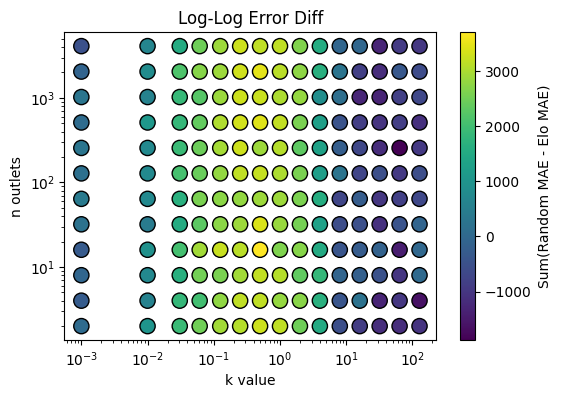

In [8]:
# K value grid search

def hp_experiment(n_outlets, k_value, n_seeds, n_iterations=1000):

    diffs = []
    for _ in range(n_seeds):
        seed = np.random.randint(0, 10000)
        ground_truth = generate_ground_truth(n_outlets=n_outlets, seed=seed)

        result_random = run_experiment(random_pair_selector, n=n_iterations, seed=seed)

        result_elo_uncertainty = run_experiment(elo_uncertainty_selector, n=n_iterations, seed=seed, sigmoid_k=k_value)

        rank_error_diff = np.array(result_random["error_mae"]) - np.array(result_elo_uncertainty["error_mae"])
        diffs.append(sum(rank_error_diff))

    print(f"n_outlets: {n_outlets:>3}, k: {k_value:6.4f}, diff: {np.mean(diffs)}")
    return np.mean(diffs)

n_seeds = 10
n_outlets_list = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
k_values = [0.001, 0.01, 0.030625, 0.06125, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]

xs, ys, cs = [], [], []
for n_outlets in n_outlets_list:
    for k in k_values:
        diff = hp_experiment(n_outlets=n_outlets, k_value=k, n_seeds=n_seeds, n_iterations=1000)
        xs.append(k)
        ys.append(n_outlets)
        cs.append(diff)

plt.figure(figsize=(6, 4))
sc = plt.scatter(xs, ys, c=cs, cmap='viridis', s=120, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(sc, label='Sum(Random MAE - Elo MAE)')
plt.xlabel('k value')
plt.ylabel('n outlets')
plt.title('Log-Log Error Diff')
plt.show()

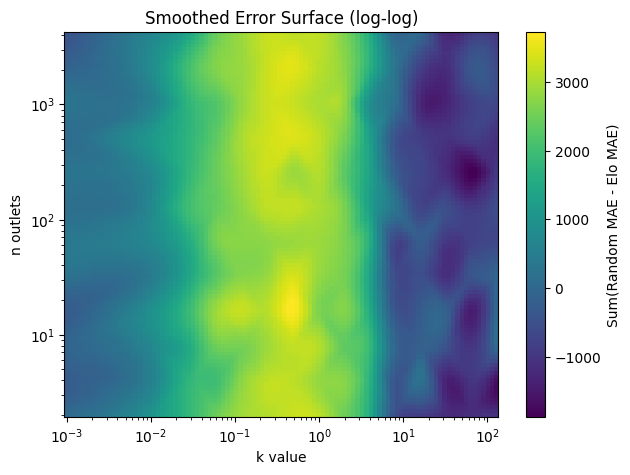

In [9]:
x = np.log10(xs)
y = np.log10(ys)
z = np.array(cs)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
XI, YI = np.meshgrid(xi, yi)

ZI = griddata((x, y), z, (XI, YI), method='cubic')

plt.figure(figsize=(7, 5))
plt.pcolormesh(10**XI, 10**YI, ZI, shading='auto', cmap='viridis')
plt.xscale('log'); plt.yscale('log')
plt.colorbar(label='Sum(Random MAE - Elo MAE)')
plt.xlabel('k value'); plt.ylabel('n outlets')
plt.title('Smoothed Error Surface (log-log)')
plt.show()